In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
from progressbar import progressbar as pbar

from omegaconf import OmegaConf
import hydra

%load_ext autoreload
%autoreload 2

check that neighbor files are a subset of original chip IDs

In [2]:
df = pd.read_parquet('/opt/data/california-naip-chips/california-naip-chips-100k.parquet')
original_chip_IDs = df['original_chip_id']

In [3]:
folder = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours"
files = pd.Series([f.removesuffix('.parquet') for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))
                   and f != 'osm_aggregate.parquet'])
files.isin(original_chip_IDs).all()

True

In [4]:
folder = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours/npy"
files = pd.Series([f.removesuffix('.npy') for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
files.isin(original_chip_IDs).all()

True

---

load the dataloader

In [5]:
conf = OmegaConf.load("../../configs/naip-multilabel-contextual.yaml")
conf.dataloader.neighbor_embeddings_folder = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours/npy"
conf.dataloader.batch_size = 16
dl = hydra.utils.instantiate(conf.dataloader)

2024-06-17 13:45:18.071 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:101 - using embeddings found in metadata file
2024-06-17 13:45:18.073 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - read train split with 72268 chip files (out of 72268)
2024-06-17 13:45:18.073 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:118 - removing chip IDs with no associated neighbors .npy files
2024-06-17 13:45:18.884 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:128 - max cache size is -1
2024-06-17 13:45:20.231 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:101 - using embeddings found in metadata file
2024-06-17 13:45:20.233 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - read val split with 14770 chip files (out of 14770)
2024-06-17 13:45:20.234 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:118 - removing chip IDs with no associate

---

test the dataset

In [6]:
x = dl.train_dataset[0]
print(x['multilabel'].shape)
x['embedding'].shape

torch.Size([140, 17, 17])


torch.Size([768, 17, 17])

In [7]:
x['multilabel'].sum(dim=(1,2))

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,
         0,  0,  0,  9,  1,  0,  0, 12,  0,  0,  4,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         8,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  3])

In [8]:
print(x['chip_id'])
print(f'{df.reset_index().set_index('original_chip_id')['chip_id'].loc[x['chip_id']]}.parquet')

ca_m_3411730_sw_11_060_20220501-36-11
1bc5059a8c325.parquet


In [9]:
file = f'{df.reset_index().set_index('original_chip_id')['chip_id'].loc[x['chip_id']]}.parquet'
z = gpd.read_parquet(f'/opt/data/california-naip-chips/osm/{file}')
z.explore()

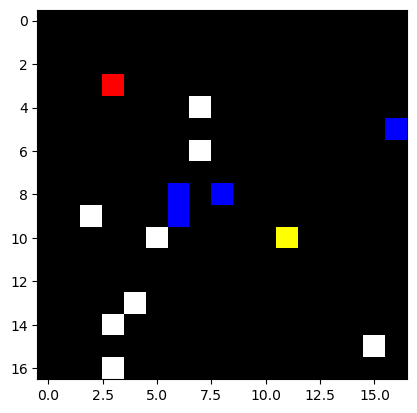

In [10]:
# plt.imshow(x['multilabel'][[43]].permute(1, 2, 0));
# plt.imshow(x['multilabel'][[39]].permute(1, 2, 0));
# plt.imshow(x['multilabel'][[34]].permute(1, 2, 0));
plt.imshow(np.rot90(x['multilabel'][[34, 39, 43]].float().permute(1,2,0)));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


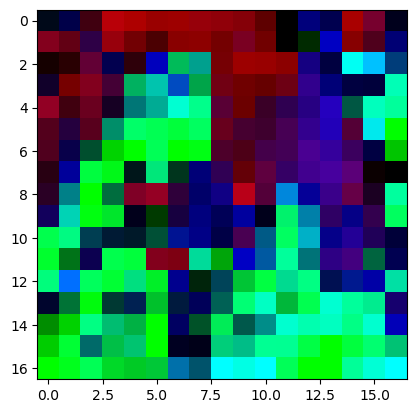

In [11]:
plt.imshow(np.rot90(x['embedding'][[25, 123, 743]].permute(1, 2, 0)));

---

test the dataloader

In [12]:
dltrain = dl.train_dataloader()

In [13]:
batch = next(iter(dltrain))

In [14]:
print(batch['embedding'].shape)
print(batch['multilabel'].shape)

torch.Size([16, 768, 17, 17])
torch.Size([16, 140, 17, 17])


---

smaller neighborhood radius

In [15]:
conf.dataloader.neighborhood_radius = 5
dl = hydra.utils.instantiate(conf.dataloader)

2024-06-17 13:46:00.680 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:101 - using embeddings found in metadata file
2024-06-17 13:46:00.682 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - read train split with 72268 chip files (out of 72268)
2024-06-17 13:46:00.683 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:118 - removing chip IDs with no associated neighbors .npy files
2024-06-17 13:46:01.502 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:128 - max cache size is -1
2024-06-17 13:46:02.986 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:101 - using embeddings found in metadata file
2024-06-17 13:46:02.990 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - read val split with 14770 chip files (out of 14770)
2024-06-17 13:46:02.990 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:118 - removing chip IDs with no associate

In [16]:
dl.train_dataset[0]['embedding'].shape

torch.Size([768, 11, 11])

In [17]:
dltrain = dl.train_dataloader()
batch = next(iter(dltrain))
print(batch['embedding'].shape)
print(batch['multilabel'].shape)

torch.Size([16, 768, 11, 11])
torch.Size([16, 140, 11, 11])
